In [1]:
import matplotlib as mpl
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv('data/final_train_data.csv', header = None)
data=df.values[1:]
data=data.astype(float)
X_train=data[:,0:22]
y_train=data[:,22]
y_train=y_train.astype(int)

df = pd.read_csv('data/final_test_data.csv', header = None)
data=df.values[1:]
data=data.astype(float)
X_test=data[:,0:22]
y_test=data[:,22]
y_test=y_test.astype(int)


y_train = tf.one_hot(y_train,10)
y_test = tf.one_hot(y_test,10)

In [3]:
# 构建神经网络(4层、1 input,2hidden,ioutput）
n_uint_hidden_1 = 256
n_uint_hidden_2 = 128
n_input = 22#输入的一个样本是15*16像素的
n_classes = 10#输出类别数目

In [4]:
# 定义输入占位符
x = tf.placeholder(tf.float32,shape = [None,n_input],name = 'x')
y = tf.placeholder(tf.float32,shape = [None,n_classes],name = 'y')

In [5]:
# 初始化的w和b

weights = {
    "w1":tf.Variable(tf.random_normal(shape=[n_input,n_uint_hidden_1],stddev = 0.1)),
    "w2":tf.Variable(tf.random_normal(shape=[n_uint_hidden_1,n_uint_hidden_2],stddev = 0.1)),
    "w3":tf.Variable(tf.random_normal(shape=[n_uint_hidden_2,n_classes],stddev = 0.1))
}

biases = {
    "b1":tf.Variable(tf.random_normal(shape=[n_uint_hidden_1],stddev=0.1)),
    "b2":tf.Variable(tf.random_normal(shape=[n_uint_hidden_2],stddev=0.1)),
    "out":tf.Variable(tf.random_normal(shape=[n_classes],stddev=0.1))
}

In [6]:
# 构建网络
def multiplayer_perceotron(_X,_weights,_biases):
#  第一层到第二层  input --> hidden1
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(_X,_weights['w1']),_biases['b1']))
#  第二层到第三层  hidden1 --> hidden
    layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1,_weights['w2']),_biases['b2']))
    return tf.add(tf.matmul(layer2,_weights['w3']),_biases['out'])

In [7]:
# 获取预测值
act= multiplayer_perceotron(x,weights,biases)

# tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y)
cost = tf.reduce_mean(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=act,labels=y)))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
# 使用梯度下降法求解
# 使用梯度下降最小化误差
# learning_rate:要注意,不要过大,过大可能不收敛,也不要过小,过小收敛速度比较慢
train = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

In [9]:
# 得到预测的类别是哪一个
# tf.argmax:对矩阵按行或列计算最大值对应的下标,和numpy中的一样
# tf.equal:是对比这两个矩阵或者向量的相等的元素,如果是相等的那就返回True
pred = tf.equal(tf.argmax(act,axis=1),tf.argmax(y,axis=1))
# 正确率(True转换为1,False转换为0)
acc = tf.reduce_mean(tf.cast(pred,tf.float32))#计算pred的平均值
# 计算 f1
model_pred = tf.argmax(act, 1)
model_True=tf.argmax(y,1)

In [10]:
# 初始化
init = tf.global_variables_initializer()

In [11]:
# 执行模型的训练
batch_size = 100  #每次处理的图片数
display_step = 4  #每4次迭代打印一次
times=2000

In [12]:
history={'loss':[],'val_loss':[],'accuracy':[],'val_accuracy':[]}

In [13]:
from sklearn.metrics import f1_score
with tf.Session() as sess:
    sess.run(init)
    y_train, y_test = sess.run([y_train,y_test])
#     模型的保存、持久化
    saver = tf.train.Saver()
    epoch = 0
    for temp in range(times):
        avg_cost = 0
        # 计算出总的批次
        total_batch = int(1500/batch_size)
        # 迭代更新
        for i in range(total_batch):
            batch_xs= X_train[i*batch_size:(i+1)*batch_size,:]
            batch_ys= y_train[i*batch_size:(i+1)*batch_size]
            feeds = {x:batch_xs,y:batch_ys}
        #           #模型训练
            sess.run(train,feed_dict=feeds)
            avg_cost+=sess.run(cost,feed_dict=feeds)
        avg_cost = avg_cost/total_batch
    #       显示误差率和训练集的正确率以此测试集的正确率
        if (epoch+1)%display_step == 0:
            print("批次:%03d  损失函数值:%.9f"%(epoch,avg_cost))
            feeds = {x:X_train,y:y_train}
            train_acc = sess.run(acc,feed_dict=feeds)
            print("训练集准确率:%.3f"%train_acc)
            feeds = {x:X_test, y: y_test}
            test_acc,y_pred,y_true,costval = sess.run([acc,model_pred,model_True,cost], feed_dict=feeds)
            model_f1_score=f1_score(y_true,y_pred,average='micro')
            print( 'f1_score= "{:.9f}"'.format(model_f1_score))
            print("测试集准确率:%.3f" % test_acc)
            history['loss'].append(avg_cost)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(costval)
            history['val_accuracy'].append(test_acc)
            if train_acc>0.9 and test_acc>0.94:
                saver.save(sess,'./mn/model')
        epoch += 1

批次:003  损失函数值:nan
训练集准确率:0.110
f1_score= "0.140625000"
测试集准确率:0.141
批次:007  损失函数值:nan
训练集准确率:0.102
f1_score= "0.106250000"
测试集准确率:0.106
批次:011  损失函数值:nan
训练集准确率:0.167
f1_score= "0.125000000"
测试集准确率:0.125
批次:015  损失函数值:nan
训练集准确率:0.314
f1_score= "0.253125000"
测试集准确率:0.253
批次:019  损失函数值:nan
训练集准确率:0.441
f1_score= "0.340625000"
测试集准确率:0.341
批次:023  损失函数值:nan
训练集准确率:0.579
f1_score= "0.428125000"
测试集准确率:0.428
批次:027  损失函数值:nan
训练集准确率:0.716
f1_score= "0.496875000"
测试集准确率:0.497
批次:031  损失函数值:nan
训练集准确率:0.837
f1_score= "0.537500000"
测试集准确率:0.538
批次:035  损失函数值:nan
训练集准确率:0.898
f1_score= "0.578125000"
测试集准确率:0.578
批次:039  损失函数值:nan
训练集准确率:0.930
f1_score= "0.625000000"
测试集准确率:0.625
批次:043  损失函数值:nan
训练集准确率:0.948
f1_score= "0.675000000"
测试集准确率:0.675
批次:047  损失函数值:nan
训练集准确率:0.959
f1_score= "0.737500000"
测试集准确率:0.738
批次:051  损失函数值:nan
训练集准确率:0.968
f1_score= "0.775000000"
测试集准确率:0.775
批次:055  损失函数值:nan
训练集准确率:0.973
f1_score= "0.790625000"
测试集准确率:0.791
批次:059  损失函数值:nan
训练集准确率:0.976
f1_score= "0.8156

批次:487  损失函数值:nan
训练集准确率:0.988
f1_score= "0.890625000"
测试集准确率:0.891
批次:491  损失函数值:nan
训练集准确率:0.988
f1_score= "0.890625000"
测试集准确率:0.891
批次:495  损失函数值:nan
训练集准确率:0.988
f1_score= "0.890625000"
测试集准确率:0.891
批次:499  损失函数值:nan
训练集准确率:0.988
f1_score= "0.890625000"
测试集准确率:0.891
批次:503  损失函数值:nan
训练集准确率:0.988
f1_score= "0.890625000"
测试集准确率:0.891
批次:507  损失函数值:nan
训练集准确率:0.988
f1_score= "0.890625000"
测试集准确率:0.891
批次:511  损失函数值:nan
训练集准确率:0.988
f1_score= "0.890625000"
测试集准确率:0.891
批次:515  损失函数值:nan
训练集准确率:0.988
f1_score= "0.890625000"
测试集准确率:0.891
批次:519  损失函数值:nan
训练集准确率:0.988
f1_score= "0.890625000"
测试集准确率:0.891
批次:523  损失函数值:nan
训练集准确率:0.988
f1_score= "0.890625000"
测试集准确率:0.891
批次:527  损失函数值:nan
训练集准确率:0.988
f1_score= "0.890625000"
测试集准确率:0.891
批次:531  损失函数值:nan
训练集准确率:0.988
f1_score= "0.890625000"
测试集准确率:0.891
批次:535  损失函数值:nan
训练集准确率:0.988
f1_score= "0.890625000"
测试集准确率:0.891
批次:539  损失函数值:nan
训练集准确率:0.988
f1_score= "0.890625000"
测试集准确率:0.891
批次:543  损失函数值:nan
训练集准确率:0.988
f1_score= "0.8906

批次:971  损失函数值:nan
训练集准确率:0.992
f1_score= "0.884375000"
测试集准确率:0.884
批次:975  损失函数值:nan
训练集准确率:0.992
f1_score= "0.884375000"
测试集准确率:0.884
批次:979  损失函数值:nan
训练集准确率:0.992
f1_score= "0.884375000"
测试集准确率:0.884
批次:983  损失函数值:nan
训练集准确率:0.992
f1_score= "0.881250000"
测试集准确率:0.881
批次:987  损失函数值:nan
训练集准确率:0.992
f1_score= "0.881250000"
测试集准确率:0.881
批次:991  损失函数值:nan
训练集准确率:0.992
f1_score= "0.881250000"
测试集准确率:0.881
批次:995  损失函数值:nan
训练集准确率:0.992
f1_score= "0.881250000"
测试集准确率:0.881
批次:999  损失函数值:nan
训练集准确率:0.992
f1_score= "0.881250000"
测试集准确率:0.881
批次:1003  损失函数值:nan
训练集准确率:0.992
f1_score= "0.881250000"
测试集准确率:0.881
批次:1007  损失函数值:nan
训练集准确率:0.992
f1_score= "0.881250000"
测试集准确率:0.881
批次:1011  损失函数值:nan
训练集准确率:0.992
f1_score= "0.881250000"
测试集准确率:0.881
批次:1015  损失函数值:nan
训练集准确率:0.992
f1_score= "0.878125000"
测试集准确率:0.878
批次:1019  损失函数值:nan
训练集准确率:0.992
f1_score= "0.878125000"
测试集准确率:0.878
批次:1023  损失函数值:nan
训练集准确率:0.992
f1_score= "0.878125000"
测试集准确率:0.878
批次:1027  损失函数值:nan
训练集准确率:0.992
f1_score= 

批次:1447  损失函数值:nan
训练集准确率:0.994
f1_score= "0.868750000"
测试集准确率:0.869
批次:1451  损失函数值:nan
训练集准确率:0.994
f1_score= "0.868750000"
测试集准确率:0.869
批次:1455  损失函数值:nan
训练集准确率:0.994
f1_score= "0.868750000"
测试集准确率:0.869
批次:1459  损失函数值:nan
训练集准确率:0.994
f1_score= "0.868750000"
测试集准确率:0.869
批次:1463  损失函数值:nan
训练集准确率:0.994
f1_score= "0.868750000"
测试集准确率:0.869
批次:1467  损失函数值:nan
训练集准确率:0.994
f1_score= "0.868750000"
测试集准确率:0.869
批次:1471  损失函数值:nan
训练集准确率:0.994
f1_score= "0.868750000"
测试集准确率:0.869
批次:1475  损失函数值:nan
训练集准确率:0.994
f1_score= "0.868750000"
测试集准确率:0.869
批次:1479  损失函数值:nan
训练集准确率:0.994
f1_score= "0.868750000"
测试集准确率:0.869
批次:1483  损失函数值:nan
训练集准确率:0.994
f1_score= "0.868750000"
测试集准确率:0.869
批次:1487  损失函数值:nan
训练集准确率:0.994
f1_score= "0.868750000"
测试集准确率:0.869
批次:1491  损失函数值:nan
训练集准确率:0.994
f1_score= "0.868750000"
测试集准确率:0.869
批次:1495  损失函数值:nan
训练集准确率:0.994
f1_score= "0.868750000"
测试集准确率:0.869
批次:1499  损失函数值:nan
训练集准确率:0.994
f1_score= "0.868750000"
测试集准确率:0.869
批次:1503  损失函数值:nan
训练集准确率:0.994
f1

批次:1923  损失函数值:nan
训练集准确率:0.994
f1_score= "0.865625000"
测试集准确率:0.866
批次:1927  损失函数值:nan
训练集准确率:0.994
f1_score= "0.865625000"
测试集准确率:0.866
批次:1931  损失函数值:nan
训练集准确率:0.994
f1_score= "0.865625000"
测试集准确率:0.866
批次:1935  损失函数值:nan
训练集准确率:0.994
f1_score= "0.865625000"
测试集准确率:0.866
批次:1939  损失函数值:nan
训练集准确率:0.994
f1_score= "0.865625000"
测试集准确率:0.866
批次:1943  损失函数值:nan
训练集准确率:0.994
f1_score= "0.865625000"
测试集准确率:0.866
批次:1947  损失函数值:nan
训练集准确率:0.994
f1_score= "0.865625000"
测试集准确率:0.866
批次:1951  损失函数值:nan
训练集准确率:0.994
f1_score= "0.865625000"
测试集准确率:0.866
批次:1955  损失函数值:nan
训练集准确率:0.994
f1_score= "0.865625000"
测试集准确率:0.866
批次:1959  损失函数值:nan
训练集准确率:0.994
f1_score= "0.865625000"
测试集准确率:0.866
批次:1963  损失函数值:nan
训练集准确率:0.994
f1_score= "0.865625000"
测试集准确率:0.866
批次:1967  损失函数值:nan
训练集准确率:0.994
f1_score= "0.865625000"
测试集准确率:0.866
批次:1971  损失函数值:nan
训练集准确率:0.994
f1_score= "0.865625000"
测试集准确率:0.866
批次:1975  损失函数值:nan
训练集准确率:0.994
f1_score= "0.865625000"
测试集准确率:0.866
批次:1979  损失函数值:nan
训练集准确率:0.994
f1

In [14]:
# 构造绘图函数
from matplotlib import pyplot as plt
def drow(history):
    epochs = range(1, len(history['loss']) + 1)
    plt.plot(epochs, history['loss'], 'rx', label='Training loss')
    plt.plot(epochs, history['val_loss'], 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

#     plt.imsave('E:/acc_and_loss/Training and Validation loss.jpg')

    plt.figure()
    epochs = range(1, len(history['accuracy']) + 1)
    plt.plot(epochs, history['accuracy'], 'rx', label='Training acc')
    plt.plot(epochs, history['val_accuracy'], 'b', label='validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('acc')
    plt.legend()

#     plt.imsave('E:/acc_and_loss/Training and validation acc.jpg')
    plt.show()

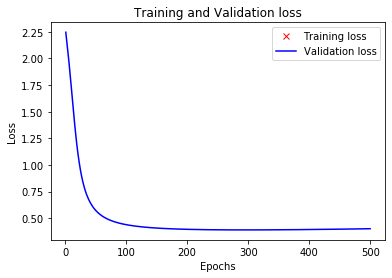

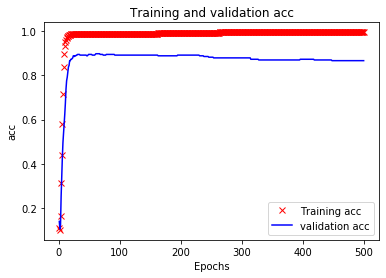

In [15]:
drow(history)